# Feature Engineering

- **Purpose:** Missing value handling and feature engineering for fraud detection  
- **Author:** Devbrew LLC  
- **Last Updated:** October 21, 2025  
- **Status:** Complete 
- **License:** Apache 2.0 (Code) | Non-commercial (Data)

---

## Dataset License Notice

This notebook uses the **IEEE-CIS Fraud Detection dataset** from Kaggle.

**Dataset License:** Non-commercial research use only
- You must download the dataset yourself from [Kaggle IEEE-CIS Competition](https://www.kaggle.com/c/ieee-fraud-detection)
- You must accept the competition rules before downloading
- Cannot be used for commercial purposes
- Cannot redistribute the raw dataset

**Setup Instructions:** See [`../data_catalog/README.md`](../data_catalog/README.md) for download instructions.

**Code License:** This notebook's code is licensed under Apache 2.0 (open source).

---

## Notebook Configuration

### Environment Setup

We configure the Python environment with standardized settings, import required libraries, and set a fixed random seed for reproducibility. This ensures consistent results across runs and enables reliable experimentation.

These settings establish the foundation for all feature engineering operations.

In [1]:
import warnings
from pathlib import Path
import json
from typing import Optional, Tuple, List

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", '{:.2f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment configured successfully")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")

Environment configured successfully
pandas: 2.3.3
numpy: 2.3.3


### Path Configuration

We define the project directory structure and validate that required processed data from the exploration phase exists. The validation ensures we have the necessary inputs before proceeding with feature engineering.

This configuration pattern ensures we can locate all required data artifacts from previous pipeline stages.

In [2]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
PROCESSED_DIR = DATA_DIR / "processed"
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Ensure processed directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Validate required data
def validate_required_data() -> dict:
    """Validate that required datasets exist before feature engineering"""
    paths_status = {
        'IEEE Train Transaction:': (IEEE_CIS_DIR / 'train_transaction.csv').exists(),
        'IEEE Train Identity:': (IEEE_CIS_DIR / 'train_identity.csv').exists(),
    }

    print("Data Availability Check:")
    for name, exists in paths_status.items():
        status = "Found" if exists else "Missing"
        print(f" - {name} {status}")
    
    all_exist = all(paths_status.values())
    if not all_exist:
        print("\n[WARNING] Some datasets are missing; see data_catalog/README.md for instructions")
    else:
        print("\nAll required datasets are available")
    
    return paths_status
    
path_status = validate_required_data()

Data Availability Check:
 - IEEE Train Transaction: Found
 - IEEE Train Identity: Found

All required datasets are available


## Helper Functions

We define reusable utilities for missing value analysis, imputation strategies, and feature engineering operations. These functions implement error handling, type hints, and standardized output formats following production best practices.

These utilities form the foundation for all feature engineering operations and enable reproducible, maintainable code.

In [3]:
def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Comprehensive missing value analysis with categorization.

    Args:
        df: DataFrame to analyze

    Returns:
        DataFrame with missing value statistics
    """
    missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        "column": missing_pct.index,
        "missing_pct": missing_pct.values,
        "missing_count": df.isnull().sum().values
    })

    # Categorize by severity
    missing_summary['category'] = pd.cut(
        missing_summary['missing_pct'],
        bins=[0, 0.1, 50, 90, 100],
        labels=['very_low', 'low', 'medium', 'high']
    )
    
    return missing_summary

def apply_missing_value_strategy(
    df: pd.DataFrame,
    drop_threshold: float = 90.0,
    ) -> Tuple[pd.DataFrame, List[str]]:
    """
    Apply missing value handling strategy

    Strategy:
    - Drop columns with > 90% missing values
    - Impute numeric columns with median
    - Impute categorical columns with mode or "Unknown"
    

    Args:
        df: DataFrame to process
        drop_threshold: Percentage threshold for dropping columns

    Returns:
        Tuple of (cleaned_df, dropped_columns)
    """
    print("Applying Missing Value Strategy\n")

    # Analyze missing values
    missing_summary = analyze_missing_values(df)
   
    # Identity columns to drop
    cols_to_drop = missing_summary[missing_summary['missing_pct'] > drop_threshold]['column'].tolist()

    print(f"Dropping {len(cols_to_drop)} columns with > {drop_threshold}% missing values: {cols_to_drop}")
    df_clean = df.drop(columns=cols_to_drop)

    # Separate numeric and categorical columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

    # Remove target if present
    if 'isFraud' in numeric_cols:
        numeric_cols.remove('isFraud')
    

    # Impute numeric with median
    print(f"\nImputing {len([col for col in numeric_cols if df_clean[col].isnull().any()])} numeric columns with median")

    for col in numeric_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
    
    # Impute categorical with mode or "Unknown"
    print(f"\nImputing {len([col for col in categorical_cols if df_clean[col].isnull().any()])} categorical columns with mode or 'Unknown'")
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()
            if len(mode_val) > 1:
                df_clean[col].fillna(mode_val[0], inplace=True)
            else:
                df_clean[col].fillna("Unknown", inplace=True)
    
    # Verify
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\nMissing values after strategy: {remaining_missing}")
    print(f"Final shape: {df_clean.shape}")

    return df_clean, cols_to_drop

def calculate_velocity_features(
    df: pd.DataFrame,
    group_col: str,
    time_col: str,
    windows: List[int] = [3600, 86400],
    ) -> pd.DataFrame:
    """
    Calculate transaction velocity features (count in time window).

    Args:
        df: DataFrame sorted by time
        group_col: Column to group by (e.g. user_id)
        time_col: Column containing transaction timestamps
        windows: Time windows in seconds [1h=3600, 24h=86400]

    Returns:
        DataFrame with velocity columns added
    """
    print(f"Calculating Velocity Features for {group_col}\n")

    df = df.sort_values([group_col, time_col]).reset_index(drop=True)
    
    for window in windows:
        window_name = f"{window/3600}h" if window >= 3600 else f"{window}s"
        col_name = f'{group_col}_txn_{window_name}'

        print(f"Calculating {col_name}...")

        # Use rolling window
        df[col_name] = df.groupby(group_col)[time_col].transform(
            lambda x: x.rolling(window=len(x), min_periods=1).apply(
                lambda times: ((times.iloc[-1] - times) <= window).sum() - 1,
                raw=False
            )
        )
    
    print(f"\nVelocity features created!")
    return df

def engineer_time_features(df: pd.DataFrame, time_col: str = 'TransactionDT') -> pd.DataFrame:
    """
    Engineer time-based features from transaction timestamp.

    Args:
        df: DataFrame with time column
        time_col: Name of time column (seconds since reference)

    Returns:
        DataFrame with time features added
    """
    print(f"Engineering Time Features")

    df[f'{time_col}_hour'] = (df[time_col] // 3600 )% 24
    df[f'{time_col}_day'] = (df[time_col] // 86400 )% 7
    df[f'{time_col}_is_weekend'] = df[f'{time_col}_day'].isin([5,6]).astype(int)

    print(f'Created: {time_col}_hour, {time_col}_day, {time_col}_is_weekend features')
    return df

def engineer_device_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer device reuse features.

    Args:
        df: DataFrame with DeviceInfo column

    Returns:
        DataFrame with device features added
    """
    print("Engineering Device Features")
    
    if 'DeviceInfo' not in df.columns:
        print(f"[WARNING] DeviceInfo not found. Skipping device features.")
        return df

    # Cards per device
    device_card_counts = df.groupby('DeviceInfo')['card1'].nunique().to_dict()
    df['device_card_count'] = df['DeviceInfo'].map(device_card_counts)

    # Multi-card device flag
    df['device_multi_card'] = (df['device_card_count'] > 1).astype(int)

    print(f"Created: device_card_count, device_multi_card features")
    return df

def engineer_amount_features(df: pd.DataFrame, amount_col: str = 'TransactionAmt') -> pd.DataFrame:
    """
    Engineer amount-based statistical features.

    Args:
        df: DataFrame with amount column
        amount_col: Name of amount column

    Returns:
        DataFrame with amount features added
    """
    print("Engineering Amount Features")

    if 'card1' not in df.columns:
        print(f"[WARNING] card1 not found. Skipping amount features.")
        return df
    
    # Per-card statistics
    cards_stats = df.groupby('card1')[amount_col].agg(['mean', 'std']).reset_index()
    cards_stats.columns = ['card1', 'card_amt_mean', 'card_amt_std']

    df = df.merge(cards_stats, on='card1', how='left')

    # fill NaN in std (cards with single transaction)
    df['card_amt_std'].fillna(0, inplace=True) 
    df['card_amt_mean'].fillna(df[amount_col].median(), inplace=True)

    # Z-score
    df['amt_zscore'] = (df[amount_col] - df['card_amt_mean']) / (df['card_amt_std'] + 1e-6)

    df['amt_zscore'].fillna(0, inplace=True)
    
    print(f"Created: card_amt_mean, card_amt_std, amt_zscore features")
    return df

print('Helper functions loaded')    

Helper functions loaded


## Load and Merge IEEE-CIS Data

We load the full IEEE-CIS training dataset (transaction and identity tables) and merge them for feature engineering. This represents the complete dataset after initial exploration.

The merged dataset serves as the foundation for all missing value handling and feature engineering operations.

In [4]:
print("Loading IEEE-CIS Training Data...\n")

# Load transaction data
train_transaction = pd.read_csv(IEEE_CIS_DIR / "train_transaction.csv")
print(f"Loaded train_transaction: {train_transaction.shape}")

# Load identity data
train_identity = pd.read_csv(IEEE_CIS_DIR / "train_identity.csv")
print(f"Loaded train_identity: {train_identity.shape}")

# Merge datasets on TransactionID
train_df = train_transaction.merge(train_identity, on="TransactionID", how="left")
print(f"Merged dataset: {train_df.shape[0]} rows x {train_df.shape[1]} columns")
print(f"Memory usage: {train_df.memory_usage().sum() / 1e9:.2f} GB")

# Show basic info
print(f"\nTarget variable (isFraud):")
print(train_df['isFraud'].value_counts())
print(f"Fraud rate: {train_df['isFraud'].mean() * 100:.2f}%")

Loading IEEE-CIS Training Data...

Loaded train_transaction: (590540, 394)
Loaded train_identity: (144233, 41)
Merged dataset: 590540 rows x 434 columns
Memory usage: 2.05 GB

Target variable (isFraud):
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%


### Data Quality Validation

We validate the merge integrity and analyze the IEEE-CIS dataset's structural characteristics. The identity table is intentionally sparse - only ~24% of transactions have associated identity verification data.

This sparsity is a known feature of the dataset and reflects real-world scenarios where identity information is not always available for every transaction. We verify the merge correctness and quantify missing data patterns before proceeding with feature engineering.

In [5]:
print("Merge Validation\n")

# Verify merge integrity
expected_rows = len(train_transaction)
expected_cols = len(train_transaction.columns) + len(train_identity.columns) - 1 # -1 for shared TransactionID

print(f"Expected shape: {expected_rows:,} rows x {expected_cols} columns")
print(f"Actual shape: {train_df.shape[0]:,} rows x {train_df.shape[1]:,} columns")
print(f"Merge integrity: {'PASS' if train_df.shape == (expected_rows, expected_cols) else 'FAIL'}")

# Analyze identity data coverage
identity_cols = [col for col in train_df.columns if col.startswith('id_') or col in ['DeviceType', 'DeviceInfo']]

rows_with_identity = train_df[identity_cols].notna().any(axis=1).sum()
rows_without_identity = train_df[identity_cols].isna().all(axis=1).sum()

print(f"\nIdentity Data Coverage:")
print(f" - Rows with identity data:     {rows_with_identity:,} ({rows_with_identity / len(train_df) * 100:.2f}%)")
print(f" - Rows without identity data:  {rows_without_identity:,} ({rows_without_identity / len(train_df) * 100:.2f}%)")
print(f" - Identity columns:            {len(identity_cols)}")

# Check for duplicate TransactionIDs (should be 0)
duplicates = train_df['TransactionID'].duplicated().sum()
print(f"\nDuplicate Transaction IDs: {duplicates}")

if duplicates > 0:
    print("\n[WARNING]: Duplicate Transaction IDs found; consider removing duplicates before feature engineering.")
else:
    print("\nStatus: Dataset ready for feature engineering")

Merge Validation

Expected shape: 590,540 rows x 434 columns
Actual shape: 590,540 rows x 434 columns
Merge integrity: PASS

Identity Data Coverage:
 - Rows with identity data:     144,233 (24.42%)
 - Rows without identity data:  446,307 (75.58%)
 - Identity columns:            40

Duplicate Transaction IDs: 0

Status: Dataset ready for feature engineering


## Missing Value Analysis

We perform comprehensive missing value analysis to understand the extent and patterns of missingness in the dataset. This analysis categorizes columns by missingness severity and informs our imputation strategy.

Understanding missing value patterns is critical for choosing appropriate handling strategies and avoiding biased models.

Missing Value Analysis Summary
category
very_low     75
low         125
medium      202
high         12
Name: count, dtype: int64

High Missingness Columns (>90%)
Count: 12
Top 10 High Missingness Columns:
  column  missing_pct  missing_count
0  id_24        99.20              0
1  id_25        99.13              0
2  id_07        99.13              0
3  id_08        99.13              0
4  id_21        99.13              0
5  id_26        99.13              0
6  id_27        99.12           8933
7  id_23        99.12           1565
8  id_22        99.12           1577
9  dist2        93.63           4259

Medium Missingness Columns (50-90%)
Count: 202


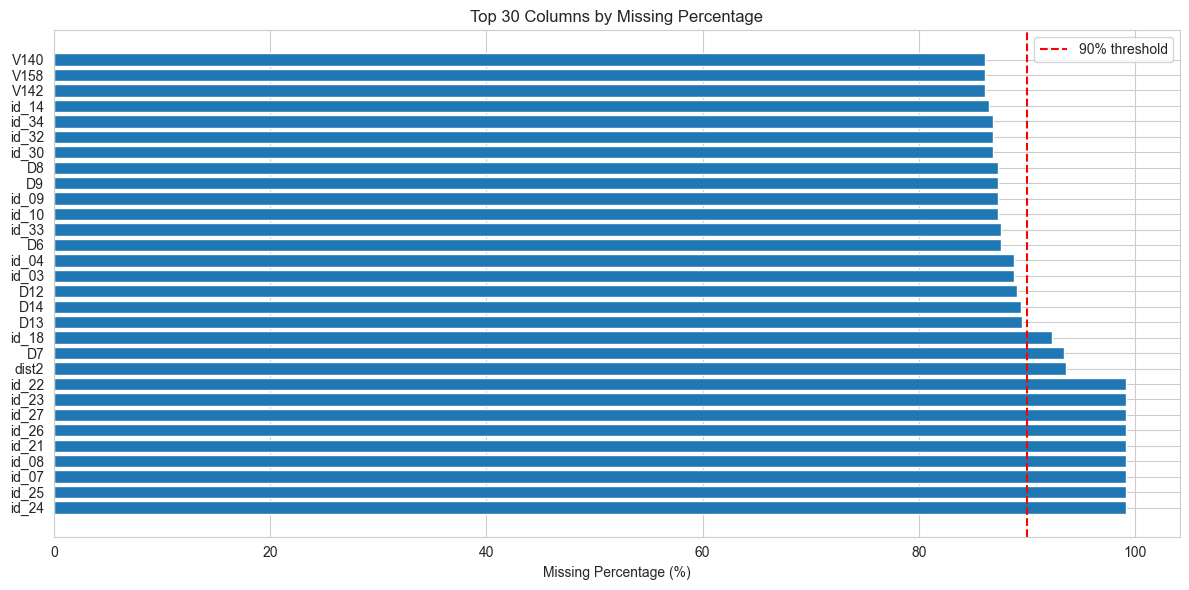

In [6]:
# Analyze missing values
missing_summary = analyze_missing_values(train_df)

# Display summary by category
print("Missing Value Analysis Summary")
print(missing_summary['category'].value_counts().sort_index())

print("\nHigh Missingness Columns (>90%)")
high_missing = missing_summary[missing_summary['category'] == 'high']
print(f"Count: {len(high_missing)}")
if len(high_missing) > 0:
    print("Top 10 High Missingness Columns:")
    print(high_missing.head(10)[['column', 'missing_pct', 'missing_count']])

print("\nMedium Missingness Columns (50-90%)")
medium_missing = missing_summary[missing_summary['category'] == 'medium']
print(f"Count: {len(medium_missing)}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
missing_for_plot = missing_summary[missing_summary['missing_pct'] > 0].head(30)
ax.barh(range(len(missing_for_plot)), missing_for_plot['missing_pct'])
ax.set_yticks(range(len(missing_for_plot)))
ax.set_yticklabels(missing_for_plot['column'])
ax.set_xlabel("Missing Percentage (%)")
ax.set_title("Top 30 Columns by Missing Percentage")
ax.axvline(x=90, color='red', linestyle='--', label='90% threshold')
ax.legend()
plt.tight_layout()
plt.show()

## Apply Missing Value Strategy

We apply a systematic missing value handling strategy:
1. **Drop columns with >90% missing** - too sparse to impute reliably
2. **Impute numeric columns with median** - robust to outliers
3. **Impute categorical columns with mode** - preserves distribution

This strategy balances information retention with data quality, following industry best practices for fraud detection models.

In [7]:
# Apply missing value strategy
train_df_clean, dropped_columns = apply_missing_value_strategy(train_df, drop_threshold=90.0)

# Save dropped columns metadata
dropped_cols_metadata = {
    "dropped_date": pd.Timestamp.now().isoformat(),
    'threshold': 90.0,
    'count': len(dropped_columns),
    'columns': dropped_columns,
    'reason': '>90% missing values'
}

dropped_cols_path = PROCESSED_DIR / "dropped_columns.json"
with open(dropped_cols_path, 'w') as f:
    json.dump(dropped_cols_metadata, f, indent=2)

print(f"Dropped columns metadata saved to {dropped_cols_path}")

# Save cleaned data
cleaned_data_path = PROCESSED_DIR / "train_cleaned.parquet"
train_df_clean.to_parquet(cleaned_data_path, index=False)

print(f"Cleaned data saved to {cleaned_data_path}")

Applying Missing Value Strategy

Dropping 12 columns with > 90.0% missing values: ['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'dist2', 'D7', 'id_18']

Imputing 374 numeric columns with median

Imputing 28 categorical columns with mode or 'Unknown'

Missing values after strategy: 0
Final shape: (590540, 422)
Dropped columns metadata saved to /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/dropped_columns.json
Cleaned data saved to /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/train_cleaned.parquet


## Feature Engineering

We engineer domain-specific features proven effective for fraud detection:
- **Time-based features**: Hour, day of week, weekend indicator
- **Velocity features**: Transaction counts in rolling time windows
- **Device features**: Device reuse patterns and multi-card devices
- **Amount features**: Per-card amount statistics and z-scores

These features capture behavioral patterns that distinguish fraudulent from legitimate transactions.

In [8]:
# Reload cleaned data
train_df = pd.read_parquet(PROCESSED_DIR / "train_cleaned.parquet")

print(f"Loaded cleaned data: {train_df.shape}")

# Engineer time features
train_df = engineer_time_features(train_df)

Loaded cleaned data: (590540, 422)
Engineering Time Features
Created: TransactionDT_hour, TransactionDT_day, TransactionDT_is_weekend features


In [9]:
# Engineer velocity features (this may take a few minutes)
print("Engineering velocity features (this may take a few minutes)...")
train_df = calculate_velocity_features(
    train_df,
    group_col='card1',
    time_col='TransactionDT',
    windows=[3600, 86400] # 1 hour, 24 hours
)

Engineering velocity features (this may take a few minutes)...
Calculating Velocity Features for card1

Calculating card1_txn_1.0h...
Calculating card1_txn_24.0h...

Velocity features created!


In [10]:
# Engineer device features
train_df = engineer_device_features(train_df)

Engineering Device Features
Created: device_card_count, device_multi_card features


In [11]:
# Engineer amount features
train_df = engineer_amount_features(train_df)

Engineering Amount Features
Created: card_amt_mean, card_amt_std, amt_zscore features


## Feature Engineering Summary

We review all engineered features and prepare final feature metadata for model training. This summary provides transparency into the feature engineering pipeline and enables feature tracking across experiments.

In [12]:
# Load original cleaned data to compare
original_cols = pd.read_parquet(PROCESSED_DIR / "train_cleaned.parquet").columns
new_features = [col for col in train_df.columns if col not in original_cols]

print("Feature Engineering Summary")
print(f"Original features: {len(original_cols)}")
print(f"New features: {len(new_features)}")
print(f"Total features: {len(train_df.columns)}")

print(f"\nEngineered features:")
for feat in sorted(new_features):
    print(f" - {feat}")

# Vereify no missing values
print("\nMissing values check:")
print(f"Total missing values: {train_df.isnull().sum().sum()}")

# Save feature-engineering data
features_path = PROCESSED_DIR / "train_features.parquet"
train_df.to_parquet(features_path, index=False)
print(f"\nFeature-engineered data saved to {features_path}")

# Save feature metadata
feature_metadata = {
    'engineering_date': pd.Timestamp.now().isoformat(),
    'original_features': len(original_cols),
    'engineered_features': len(new_features),
    'total_features': len(train_df.columns),
    'new_features': new_features,
    'feature_categories': {
        'time_based': [f for f in new_features if 'TransactionDT' in f],
        'velocity': [f for f in new_features if 'txn_' in f],
        'device': [f for f in new_features if 'device_' in f],
        'amount': [f for f in new_features if 'amt_' in f or 'card_amt' in f],
    },
    'dataset_shape': list(train_df.shape),
    'memory_gb': train_df.memory_usage(deep=True).sum() / 1e9
}

metadata_path = PROCESSED_DIR / "feature_engineering_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
    
print(f"\nFeature metadata saved to {metadata_path}")

Feature Engineering Summary
Original features: 422
New features: 10
Total features: 432

Engineered features:
 - TransactionDT_day
 - TransactionDT_hour
 - TransactionDT_is_weekend
 - amt_zscore
 - card1_txn_1.0h
 - card1_txn_24.0h
 - card_amt_mean
 - card_amt_std
 - device_card_count
 - device_multi_card

Missing values check:
Total missing values: 0

Feature-engineered data saved to /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/train_features.parquet

Feature metadata saved to /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/feature_engineering_metadata.json
